# TP Preuve d’Équivalence de Circuits Logiques

Dans ce TP, vous allez utiliser un outil qui sait resoudre des problèmes de type Boolean satisfyability (SAT) afin de prouver l’équivalence de deux circuits logiques.

## 1. Problème à resoudre

Nous disposons de fichiers dans un format simple représentant des circuits logiques au niveau des portes.
Il existe différents formats de ce type (comme BLIF, EDIF,...) utilisé par des outils de synthèse ou de simulation. Ces formats sont souvent pas très lisible, surtout pas pour un humain. Pour être sûr que la synthèse et l’optimisation n’ont pas introduit d’erreurs (ce qui est tout à fait possible), on utilise des outils de
preuve d’équivalence (*equivalence checker*). Par exemple, pour vérifier un nouveau type d’additionneur optimisé, on prouve qu’il est équivalent à un circuit bien connu comme un simple *carry ripple adder*.

Pour effectuer la preuve d’équivalence, vous allez vous servir d’un solveur de satisfiabilité (SAT solver). Un tel outil est capable de répondre à la question suivante:

> *Pour une formule logique en CNF (conjunctive normal form), est-ce qu’il existe une affectation des variables tel que la formule est vraie?*

Afin de pouvoir utiliser un SAT solver pour notre preuve, il faut donc trouver un moyen d’exprimer notre problème de départ comme un problème SAT. Globalement, le but de ce TP est d’implementer le design pattern *encode – solve – decode* de la manière suivante:

![encode - solve - decode](imgs/designpattern.png)

En fait, pendant ce TP, vous allez seulement vous occuper du côté *encodage*, car le *décodage* de la solution est plus ou moins trivial.

## 2. Circuits logiques combinatoires

Dans le dossier `benchmarks`, vous trouvez des exemples de fichiers qui démontrent le format textuel pour décrire des circuits logiques. La syntaxe exacte du format ne nous intéresse pas en détail, car nous disposons d’un parseur qui fera le travail de lecture pour nous. Un circuit a

* Des entrées
* Des sorties
* Des signaux internes
* Des équations Booléennes qui définissent le comportement du circuit

Tous les signaux sont de type Boolean, il n’y a pas d’entier ou de vecteur de bits. Un circuit est en fait un *graphe acyclique orienté* (DAG, *directed acyclic graph*), dont les racines sont les sorties est le feuilles les entrées. 

Voici un exemple : en éxétutant la cellule en bas, vous pouvez afficher le contenu du fichier `benchmarks/fa.circ`.

In [2]:
!cat benchmarks/fa.crc

circ full_adder {
     inputs: a, b, cin
     outputs: s, cout
     s0 = a ^ b
     s = s0 ^ cin
     cout = (a & b) | (s0 & cin)
}


On va maintenant prendre en main le code pour charger un circuit et afficher son schéma. Le résultat montre le graphe de l'additioneur (full adder) qui se trouve dans le fichier `benchmarks/fa.crc`:

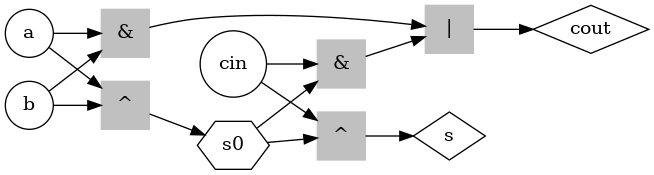

In [3]:
import circuit.circuit as circ
import os

try:
    fa = circ.parse('benchmarks/fa.crc')
except e:
    print('Could not load circuit.')
    raise e
    
def showCirc(c):
    from IPython.display import display
    from PIL import Image

    with open('circ.dot', 'w') as f:
        f.write(c.dot())
    os.system('dot -Tpng circ.dot > circ.png')     
    display(Image.open('circ.png'))

showCirc(fa) 

On voit les entrées (a, b, cin), les sorties (s, cout), un signal interne (s0) ainsi que des portes (&, ^, |). En fait, la représentation du circuit vu en haut ne correspond pas complètement à la structure de la classe `Circuit`, car il n’y a pas de connexion entre les portes *et* et *ou excluif* en haut à droite et le signal interne s0. Un objet de type `Circuit` contient plutôt un dictionnaire associant les noms des signaux internes à des noeds dans le graphe, et le graphe lui-même contient des noeds de type `Variable` avec le nom de la variable interne s0.


Une fois chargé, nous pouvons regarder les différents éléments du circuit : Les entrées, sorties, et signaux internes :

In [4]:
print ("Inputs : {}".format(fa.getInputs()))
print ("Outputs: {}".format(fa.getOutputs()))
print ("Signals: {}".format(fa.getInternalSignals()))
print ("Fanouts: {}".format(fa.getFanoutSignals()))

Inputs : {'a', 'b', 'cin'}
Outputs: {'cout', 's'}
Signals: {'s0'}
Fanouts: {'s0', 'cout', 's'}


Noter que les signaux *fanout* sont l'union des sorties et des signaux internes. Autrement dit, c'est les signaux qui sont définis par une équation booléenne dans le circuit.

On peut aussi faire une simulation d'un circuit combinatoire. La méthode `simulate` prend en entrée un dictionnaire avec les valeurs des entrées et renvoit un dictionnaire complété avec les valeurs de tous les signaux :

In [5]:
# Set input values
inputValues = {'a': 1, 'b': 1, 'cin': 0}

# Simulate full adder circuit
signalValues = fa.simulate(inputValues)
print(signalValues)

{'a': 1, 'b': 1, 'cin': 0, 's0': 0, 'cout': 1, 's': 0}


Voici le code pour afficher la table de vérité pour l'additioneur :

In [6]:
# print table header
print ("{:^3}{:^3}{:^4}|{:^4}{:^3}".format('a','b','cin','cout','s'))
print ("-" * 10 + "+" + "-" * 8)

inputs = dict()
for i in range(8):

    # Convert i to a vector of Booleans
    bits = [b=='1' for b in format(i, '03b')]

    inputs['a'] = bits[0]
    inputs['b'] = bits[1]
    inputs['cin'] = bits[2]
    signals = fa.simulate(inputs)
    print ("{:^3}{:^3}{:^4}|{:^4}{:^3}".format(inputs['a'], inputs['b'], inputs['cin'], signals['cout'], signals['s']))

 a  b cin |cout s 
----------+--------
 0  0  0  | 0   0 
 0  0  1  | 0   1 
 0  1  0  | 0   1 
 0  1  1  | 1   0 
 1  0  0  | 0   1 
 1  0  1  | 1   0 
 1  1  0  | 1   0 
 1  1  1  | 1   1 


Finalement, on va regarder la strucutre interne du circuit. Vous allez en avoir besoin plus tard. La fonction `nodeInfo()` en bas va parcourir récursivement le circuit à partir d'une racine (correspondant à un signal *fanout*) et affiche des informations comme son ID, son type ou l'opération logique:

In [7]:
def nodeInfo(node, indent=0):
    print ('{}{}'.format(' '*indent, '-'*40))
    print ('{}Node id  : {}'.format(' '*indent, node.getID()) )
    print ('{}Node type: {}'.format(' '*indent, type(node)))
    if type(node) in [circ.BinOp,circ.UnOp]:
        print ('{}Gate type: {}'.format(' '*indent, node.getOp()))
    elif type(node) is circ.Variable:
        print ('{}Variable : {}'.format(' '*indent, node.getName()))
    elif type(node is circ.Literal):
        print ('{}Value    : {}'.format(' '*indent, node.getValue()))
    if node.getChildren():
        print ('{}Children :'.format(' '*indent))
        for child in node.getChildren():
            nodeInfo(child, indent+4)

for sig in fa.getFanoutSignals():
    print ('='*40)
    print ('Signal {}'.format(sig))
    nodeInfo(fa.getNode(sig))

Signal s0
----------------------------------------
Node id  : 8
Node type: <class 'circuit.circuit.BinOp'>
Gate type: ^
Children :
    ----------------------------------------
    Node id  : 6
    Node type: <class 'circuit.circuit.Variable'>
    Variable : a
    ----------------------------------------
    Node id  : 7
    Node type: <class 'circuit.circuit.Variable'>
    Variable : b
Signal cout
----------------------------------------
Node id  : 20
Node type: <class 'circuit.circuit.BinOp'>
Gate type: |
Children :
    ----------------------------------------
    Node id  : 16
    Node type: <class 'circuit.circuit.BinOp'>
    Gate type: &
    Children :
        ----------------------------------------
        Node id  : 14
        Node type: <class 'circuit.circuit.Variable'>
        Variable : a
        ----------------------------------------
        Node id  : 15
        Node type: <class 'circuit.circuit.Variable'>
        Variable : b
    ---------------------------------------

A partir de la sortie, tracez le graphe sur une feuille de papier. Comparez la structure avec le graphe acyclique dirigé affiché en haut.

## 3. Conjunctive Normal Form

L’autre module fourni pour ce TP permet d’écrire des expressions logiques en CNF, et de les donner à un *SAT solver* pour trouver une affectation qui valide l’expression (ou qui prouve qu’il n’existe pas de telle affectation). Le code en bas montre comment déclarer des variables de SAT, écrire une expression CNF et de la résoudre par le SAT solver :

In [8]:
from circuit.cnf import SatVar, Solver, Cnf

x = SatVar('x')
y = SatVar('y')
z = SatVar('z')

cnf = (x | ~y) & (z | y)

solver = Solver()
solution = solver.solve(cnf)
print (solution)

SAT {'z': True, 'x': True, 'y': False}


Nous pouvons étendre la CNF en rajoutant des clauses...

In [9]:
cnf &= ~z
print ('CNF is now: {}'.format(cnf))
solution = solver.solve(cnf)
print (solution)

CNF is now: (x | ~y) & (z | y) & (~z)
SAT {'z': False, 'x': True, 'y': True}


... jusqu'à ce qu'il n'y a plus de solution (la formule est une contradiction) :

In [10]:
cnf &= ~y
print ('CNF is now: {}'.format(cnf))
solution = solver.solve(cnf)
print (solution)

CNF is now: (x | ~y) & (z | y) & (~z) & (~y)
UNSAT


 Comme nous avons vu dans le cours, nous pouvons nous servir de la représentation CNF et d'un SAT solver pour la vérification de circuits logiques combinatoires. Ainsi, pour modéliser une porte *ou* défini par l'équation $z \leftrightarrow a \vee b$, nous obtenons une expression équivalente en CNF :
 
 $z \leftrightarrow a \vee b \equiv (z \rightarrow a \vee b) \wedge (a \vee b \rightarrow z)$
 
 $z \leftrightarrow a \vee b \equiv (\neg z \vee a \vee b) \wedge (\neg(a \vee b) \vee z)$
 
 $z \leftrightarrow a \vee q \equiv (\neg z \vee a \vee b) \wedge ((\neg a \wedge \neg b) \vee z)$
 
 $z \leftrightarrow a \vee q \equiv (\neg z \vee a \vee b) \wedge (\neg a \vee z) \wedge (\neg b \vee z)$
 
Nous allons dans la suite définir des fonctions qui construisent des CNFs équivalentes pour chaque type de porte logique. Comme par exemple pour la porte *ou* :

In [11]:
def cnfOR(z, a, b):
    return (~z | a | b) & (~a | z) & (~b | z)

a = SatVar('a')
b = SatVar('b')
z = SatVar('z')

solver = Solver()
solution = solver.solve(cnfOR(z, a, b))
print (solution)

SAT {'a': False, 'b': False, 'z': False}


Le code en haut donne *une* solution plus ou moins par hazard. Mais la classe `Solver` offre aussi une possibilité pour énumérer *toutes les solutions* d'une CNF une par une. Dans la sortie en bas, vérifier que toutes les solutions correspondent à la fonction de la porte *ou* avec la sortie $z$ et les entrées $a$ et $b$ :

In [12]:
allSolutions = solver.allSAT(cnfOR(z, a, b))

for solution in allSolutions:
    print (solution)

SAT {'a': False, 'b': False, 'z': False}
SAT {'a': True, 'b': False, 'z': True}
SAT {'a': False, 'b': True, 'z': True}
SAT {'a': True, 'b': True, 'z': True}


### Exercise 1 : Les transformations pour toutes les portes logiques

Dans la cellule en bas, compléter toutes les fonctions avec les CNFs équivalentes aux fonctions des portes logiques. Il y a une fonction en plus des portes définies en haut (`cnfEQ(z, a)`), elle sert à construire une CNF qui exprime que $z$ et $a$ ont la même valeur.  

In [40]:
def cnfOR(z, a, b):
    """CNF for gate z <-> a | b"""
    return (~z | a | b) & (~a | z) & (~b | z)

def cnfNOT(z, a):
    """CNF for gate z <-> ~a"""
    # YOUR CODE HERE
    return (a | z) & (~z | ~a) #CORRECT

def cnfAND(z, a, b):
    """CNF for gate z <-> a & b"""
    # YOUR CODE HERE
    return (~z | a) & (~a | ~b | z) & (~z | b)
    
def cnfXOR(z, a, b):
    """CNF for gate z <-> a ^ b"""
    # YOUR CODE HERE
    # (z → a^b) & (a^b→z)
    # (~z | a^b) & (~(a^b) | z)
    # (~a imp b) & (a imp ~b) is equiv to a^b
    # ~(a imp b) .... 
    #return (~z | a | b ) & (~z | ~a | ~b) & (~(a | b) | z) & (~(~a | ~b) | z)
    return (~z | a | b ) & (~z | ~a | ~b) & (~a | b | z) & (a | ~b | z)

def cnfEQ(z, a):
    """CNF for constraint z <-> a"""
    # YOUR CODE HERE
    # (z→a) & (a→z)
    return (~z | a) & (~a | z)
    

Voici le code pour tester vos fonctions :

In [41]:
import unittest
from circuit.test import CircuitTest
from circuit.cnf import SatVar, Solver, Cnf
        
a = SatVar('a')
b = SatVar('b')
z = SatVar('z')

test = CircuitTest()
test.checkCNF(
    cnfOR(z, a, b),
    lambda s: s['z'] == s['a'] or s['b'], 4)

test.checkCNF(
    cnfNOT(z, a),
    lambda s: s['z'] == (not s['a']), 2)
        
test.checkCNF(
    cnfAND(z, a, b),
    lambda s: s['z'] == (s['a'] and s['b']), 4)

test.checkCNF(
    cnfXOR(z, a, b),
    lambda s: s['z'] == s['a'] ^ s['b'], 4)
        
test.checkCNF(
    cnfEQ(z, a),
    lambda s: s['z'] == s['a'], 2)

print ("All tests passed!")

All tests passed!


## 4. La transformation Tseytin

### Exercise 2 : Une CNF pour l'additionneur

Maintenant que l'on a des transformations individuelles pour toutes les portes logiques, nous pouvons les assembler pour transformer un circuit logique combinatoire en une CNF *équisatisfiable*. Cette transformation consiste à 
 1. Introduire des variables internes derrière chaque porte logique
 2. Remplacer chaque porte logique par la CNF correspondante
 3. Concatener (par conjunction) toutes les petites CNFs en une seule formule CNF

La CNF résultant de cette transformation n'est pas *équivalente* à la fonction du circuit d'origine dans le sens strict, parce qu'elle contient plus de variables (les variables internes de la première étape). On dit qu'elle  est *équisatisfiable*, parce que chaque solution de la CNF transformée projetée sur les variables du circuit d'origine est *consistente* avec la fonction du circuit (et vice versa). 

Dans un premier temps, vous allez faire cette transformation "à la main". Dans la cellule en bas, compléter la fonction `cnfFullAdder(a, b, cin, s, cout)`. Elle doit renvoyer une CNF équisatisfiable à l'additioneur que vous connaissez déjà. Vous êtes libre de rajouter des variables internes avec `SatVar('varname')`.

In [42]:
from circuit.cnf import SatVar, Solver, Cnf

# Interface variables
#inputs
a = SatVar('a')
b = SatVar('b')
cin = SatVar('cin')
#outputs
s = SatVar('s')
cout = SatVar('cout')

#internal variables
s0= SatVar('s0')
s1= SatVar('s1')
s2= SatVar('s2')

def cnfFullAdder(a, b, cin, s, cout):
    # YOUR CODE HERE
    return cnfXOR(s0, a, b) & cnfXOR(s, cin, s0) & cnfAND(s1, a, b) & cnfAND(s2, cin, s0) & cnfOR(cout, s1, s2)
    

In [43]:
from circuit.test import CircuitTest
from circuit.cnf import SatVar, Solver, Cnf
        
test = CircuitTest()
test.checkCNF(
    cnfFullAdder(a, b, cin, s, cout),
    lambda s: 2*s['cout'] + s['s'] == s['a'] + s['b'] + s['cin'], 8)

print ("All tests passed!")

All tests passed!


### Exercise 3 : Des contraintes supplémentaires

Nous avions constaté que la transformation de Tseytin nous donne une CNF équisatisfiable, cad que chaque solution de la CNF est *consistente* avec le circuit. Autrement dit, si nous affectons à tous les signaux les valeurs renvoyées par le SAT solver, cela correspond à un état stable ou une *simulation* du circuit. Mais attendez, on a fait toutes ces choses compliquées juste pour simuler un circuit? On aurait pu faire ça avec ModelSim et beaucoup plus rapide en plus! Alors qu'est-ce qu'on a gagné avec cette réprésentation en CNF?

Il se trouve qu'au delà de juste simuler un circuit, en rajoutant des contraintes supplémentaires à la CNF, nous pouvons formuler divers problèmes de vérification. Un exemple est l'équivalence de deux circuits, ce qui est difficile à établir juste avec une simulation. Nous pouvons aussi faire une simulation "à l'envers", cad au lieu d'affecter les entrées et de calculer les sorties en conséquence, nous pouvons affecter les *sorties* et demander au SAT solver de nous trouver des valeurs pour les entrées qui donnent ce résultat (ou de prouver qu'il n'y a pas de telles valeurs). 

Dans la cellule en bas, compléter la fonction `cnfFullAdderEqualsTwo(a, b, cin, s, cout)`. Elle doit renvoyer une CNF qui sert à trouver des valeurs des entrées $a$, $b$ et $c_{in}$ qui donnent le résultat 2 (donc $s = 0$ et $c_{out} = 1$) :

In [81]:
def cnfFullAdderEqualsTwo(a, b, cin, s, cout):
    # YOUR CODE HERE
    s=0
    cout=1
    return cnfXOR(s0, a, b) & cnfXOR(s, cin, s0) & cnfAND(s1, a, b) & cnfAND(s2, cin, s0) & cnfOR(cout, s1, s2) & ~s & cout
    #return cnfXOR(s0, a, b) & cnfXOR(0, cin, s0) & cnfAND(s1, a, b) & cnfAND(s2, cin, s0) & cnfOR(1, s1, s2)

In [82]:
from circuit.test import CircuitTest
from circuit.cnf import SatVar, Solver, Cnf
        
test = CircuitTest()
test.checkCNF(
    cnfFullAdderEqualsTwo(a, b, cin, s, cout),
    lambda s: 2 == s['a'] + s['b'] + s['cin'], 3)
        
print ("All tests passed!")

TypeError: unsupported operand type(s) for |: 'int' and 'SatVar'

### Exercise 4 : La transformation complète

Maintenant, on voudrait automatiser la transformation d'un circuit suivant la transformation Tseitin. Pour cela, vous allez implémenter une fonction qui prend en entrée un circuit et qui génère une CNF.

Il va falloir traverser la structure du graphe pour transformer chaque noed du circuit. Pour la transformation, il est très utile d’avoir un identifiant unique pour chaque noed afin d'y associer les variables (`SatVar`) pour la CNF. Pour les noeds internes, vous pouvez utiliser la fonction `getID()` qui vous donne un tel identifiant (un entier). Noter que la classe `SatVar` fait déjà une partie du travail pour vous : Si vous construisez une variable avec par exemple `SatVar('foo')`, l'objet renvoyé est associé au nom 'foo'. Ça veut dire qu'un deuxième appel -- plus tard ou dans une autre fonction -- à `SatVar('foo')` vous renvoit *la même variable*. Vous n'avez donc pas à stocker les variables dans un dictionnaire ou autre, il faut juste être sûr que vous utilisez des noms uniques pour tous les signaux du circuit.

Seule exigence pour la CNF résultante est que pour tous les signaux *nommés* (entrées, sorties, signaux internes), les noms des variables SAT correspondantes soient identiques aux noms des signaux du circuit. Si la fonction `transform()` est appelée avec un *préfix* non vide, il faut que toutes les variables portent ce préfix.

Par exemple, soit un circuit $C$ avec une sortie $sum$, nous construisons la CNF:

    cnf = transform(C, prefix='foo_')

Supposons que le SAT solver nous donne une solution pour cette CNF:

    solution = solver.solve(cnf)

On peut ensuite récupérer la valeur que le solveur à trouvé pour la sortie $sum$ ainsi :

    sum = solution['foo_sum']
   
À vous de jouer maintenant. Dans la cellule en bas, compléter la fonction `transform()`. Vous pouvez évidemment utiliser les fonctions `cnfOR()` etc pour les transformations des portes logiques. Pensez à tous les types de noeds : opérations binaires (and, or, xor), unaires (not), variables et litéraux (constante 0 ou 1).

In [68]:
def transform(c, prefix=''):
    """Tseytin transformation of circuit c"""
    # YOUR CODE HERE
    
    
    #raise NotImplementedError()
    
    

Voici quelques tests pour votre code. 

In [80]:
import circuit.circuit as circ
from circuit.cnf import SatVar, Solver, Cnf
from circuit.test import CircuitTest
 
test = CircuitTest()
test.checkTransform(transform, 'benchmarks/and.crc', max_tests=4)        
test.checkTransform(transform, 'benchmarks/or.crc', max_tests=4)
test.checkTransform(transform, 'benchmarks/xor.crc', max_tests=4)
test.checkTransform(transform, 'benchmarks/not.crc', max_tests=2)
test.checkTransform(transform, 'benchmarks/twoa.crc', max_tests=4)
test.checkTransform(transform, 'benchmarks/twob.crc', max_tests=4)
test.checkTransform(transform, 'benchmarks/fa.crc', max_tests=8)
test.checkTransform(transform, 'benchmarks/fa2.crc', max_tests=8)
test.checkTransform(transform, 'benchmarks/cra8.crc', max_tests=64)
test.checkTransform(transform, 'benchmarks/foo.crc', max_tests=16)
test.checkTransform(transform, 'benchmarks/cla8.crc', max_tests=64)
test.checkTransform(transform, 'benchmarks/csa16.crc', max_tests=64)

print ("All tests passed!")

AttributeError: 'Circuit' object has no attribute 'getSignals'

Une fois que tous les tests passent, vous pouvez continuer.

## 5. Preuve d'équivalence

Nous allons dans la suite construire un outil pour prouver l'équivalence de deux circuits logiques combinatoires, un *equivalence checker*. Pour deux circuits $C$ et $C'$ avec les mêmes entrées et sorties, nous allons construire une circuit comme sur le schéma suivant :

![Miter circuit](imgs/miter.png)

En anglais, cette construction s'appele un *miter circuit*. L'idée est de connecter les entrées correspondantes et de comparer les sorties : Pour chaque paire de sorties correspondantes, nous rajoutons une porte *ou exclusif*. Toutes les sorties des portes *ou exclusif* sont combinées avec une grande porte *ou*. On obtient donc un grand circuit avec une seule sortie dont la valeur est $1$ si et seulement si $C$ et $C'$ ne donnent pas les mêmes résultats pour les mêmes valeurs d'entrée. 

Il reste à trouver les bonnes valeurs pour les entrées $a,b,c$ pour démontrer cette différence (ou de démontrer qu'il n'y a pas de telles valeurs). Pour cela, nous allons nous servir de la transformation Tseitin et d'un SAT solver. 

### Exercise 5: Equivalence checker

Compléter dans la cellule en bas la fonction `ec()`. Elle prend en entrée deux circuits et elle renvoit une paire de valeurs. La première est un Booléen : `True` si les circuits sont équivalents, sinon `False`. La deuxième valeurs est la solution du problème SAT si elle existe, cad un contre-exmple si les circuits sont différents, et `None` s'ils sont équivalents.

Quelques astuces pour l'implémentation:

1. Utiliser la transformation Tseytin pour les deux circuits, et rajouter des portes pour la logique de comparaison. Utiliser des préfixes différents pour les deux circuits, car ils ont normalement beaucoup de noms de signaux qui sont pareil. 
1. Pour les entrées, il est demandé que la solution (en cas de non-équivalence) contient des affectations sans préfix, cad pour une entrée `foo`, on peut récupérer la valeur avec `solution['foo']`
1. Assurez-vous de couvrir les conditions de non-équivalence suivantes (et de renvoyer `(False, None)` dans ces cas):
  1. Les circuits n'ont pas le même nombre d'entrées ou de sorties
  1. Les entrées ou sorties n'ont pas les mêmes noms

  

In [ ]:
def ec(c1, c2):
    """Check equivalence of circuits c1 and c2"""
    # YOUR CODE HERE
    raise NotImplementedError()

Voici le code pour tester votre implémentation :

In [ ]:
import circuit.circuit as circ
from circuit.cnf import SatVar, Solver, Cnf
from circuit.test import CircuitTest
            
test = CircuitTest()

test.checkEquivalence(ec, 'benchmarks/and.crc', 'benchmarks/and2.crc', True)
test.checkEquivalence(ec, 'benchmarks/or.crc', 'benchmarks/or2.crc', True)
test.checkEquivalence(ec, 'benchmarks/xor.crc', 'benchmarks/xor2.crc', True)
test.checkEquivalence(ec, 'benchmarks/and.crc', 'benchmarks/or.crc', False)
test.checkEquivalence(ec, 'benchmarks/or.crc', 'benchmarks/xor.crc', False)
test.checkEquivalence(ec, 'benchmarks/twoa.crc', 'benchmarks/twob.crc', False)
test.checkEquivalence(ec, 'benchmarks/fa.crc', 'benchmarks/fa2.crc', True)
test.checkEquivalence(ec, 'benchmarks/fa.crc', 'benchmarks/fa3.crc', True)
test.checkEquivalence(ec, 'benchmarks/fa3.crc', 'benchmarks/fa2.crc', True)
test.checkEquivalence(ec, 'benchmarks/fa.crc', 'benchmarks/fa4.crc', False)
test.checkEquivalence(ec, 'benchmarks/fa2.crc', 'benchmarks/fa4.crc', False)
test.checkEquivalence(ec, 'benchmarks/fa3.crc', 'benchmarks/fa4.crc', False)
test.checkEquivalence(ec, 'benchmarks/twoa.crc', 'benchmarks/fa4.crc', False)
test.checkEquivalence(ec, 'benchmarks/cla16.crc', 'benchmarks/cra8.crc', False)
test.checkEquivalence(ec, 'benchmarks/cra16.crc', 'benchmarks/cla16.crc', True)
test.checkEquivalence(ec, 'benchmarks/cra16.crc', 'benchmarks/faulty16.crc', False)
test.checkEquivalence(ec, 'benchmarks/cra32.crc', 'benchmarks/cla32.crc', True)
test.checkEquivalence(ec, 'benchmarks/cra32.crc', 'benchmarks/faulty32.crc', False)
    
print ("All tests passed!")

Si tous les tests passent : Félicitations, vous avez fini ! Avant de soumettre votre solution, vous pouvez executer la cellule en bas pour créer un archive `submission.tgz` :

In [ ]:
!tar --create --gzip --exclude=submission.tgz --exclude=*__pycache__* ../tp-satec > submission.tgz